# Calibrating the cloud clearing algorithm
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. The IFT algorithm has a cloud clearing module that sets thresholds for intensity values channel 1 and channel 2 of the MODIS false color imagery. Let the intensity value of channel $i$ be given by $l_i$. The module then creates a binary mask with the following steps:
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $T_C$. Presently, the manual estimate of cloud fraction is our best estimate of the "truth" for the total cloud fraction $F$. The fraction of pixels with $l_1 > T_C$ is the estimated total cloud fraction $\hat{F}$. We apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. Finally, the optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ $T_C$ estimates.


In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
df = pd.read_csv('../data/cca_cases_overview.csv', index_col=0)
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.reset_index(inplace = True)
df.rename({'index': 'case_number'}, axis=1, inplace=True)
df['case_number'] = [str(x).zfill(3) for x in df['case_number']]
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]
# convert percentage to float
for case in df.loc[df.estimated_cloud_fraction.notnull()].index:
    df.loc[case, 'estimated_cloud_fraction'] = float(
        df.loc[case, 'estimated_cloud_fraction'].replace('%', ''))/100
df['estimated_cloud_fraction'] = df['estimated_cloud_fraction'].astype(float)
# convenience function to make filenames from case data table
# open to suggestions on better syntax for filenames!
def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = case_data['start_date'].strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        prefix = '_'.join([cn, region, date])
        return prefix + '_' + sat + '.tiff'
        
    elif imtype in ['truecolor', 'falsecolor']:
        prefix = '_'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_94881/378256349.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load raster data
fc_dataloc = '../data/validation_images/falsecolor/'
tc_dataloc = '../data/validation_images/truecolor/'
lb_dataloc = '../data/validation_images/labeled_floes_gtiff/'

fc_images = {}
tc_images = {}
lb_images = {}

labeled = [l.split('_')[0] + '_' + l.split('_')[-1].replace('.tiff', '')
           for l in os.listdir(lb_dataloc) if l != '.DS_Store']

for case in df.loc[df.estimated_cloud_fraction.notnull(),:].index:
    for dataloc, imtype, data_dict in zip([fc_dataloc, tc_dataloc],
                                          ['falsecolor', 'truecolor'],
                                          [fc_images, tc_images]):
        try:
            with rio.open(dataloc + fname(df.loc[case,:], imtype)) as im:
                data_dict[case] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[case,:], imtype))

for case in labeled:
    try:
        with rio.open(lb_dataloc + fname(df.loc[case,:], 'labeled')) as im:
            lb_images[case] = im.read()
    except:
        print('Couldn\'t read', fname(df.loc[case,:], imtype))

Couldn't read 134_beaufort_sea_100km_20170925.aqua.falsecolor.250m.tiff


In [3]:
# Drop case with missing falsecolor image
df = df.drop('134_aqua', axis=0)

In [4]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='estimated_cloud_fraction').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'estimated_cloud_fraction']).T

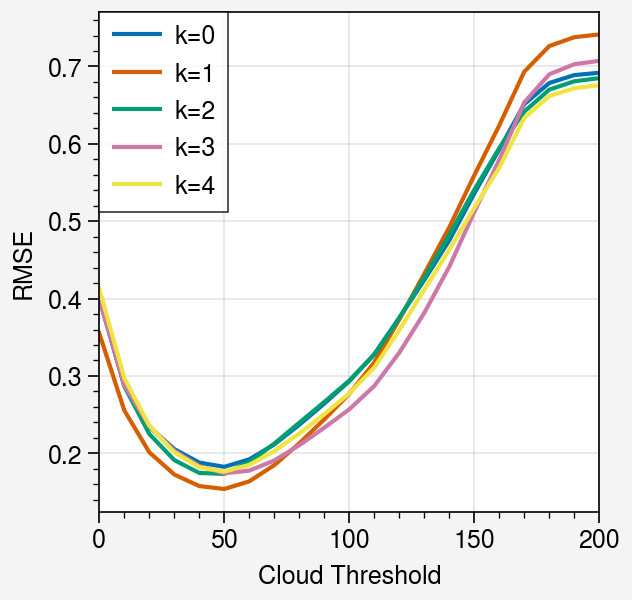

In [5]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_err)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_err.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_err.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'estimated_cloud_fraction']
            for case in test_cases])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='k=' + str(i))
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1)

In [6]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

,TC,RMSE
0,49.0,0.122928
1,48.0,0.231985
2,46.0,0.175439
3,52.0,0.170389
4,49.0,0.155100


In [8]:
kfold_results.mean(axis=0).round(2)

TC      48.80
RMSE     0.17
dtype: float64

# Results
Our initial result: optimal choice of $T_C$ is 49, with an associated error of 0.17. The error is unitless, as it is an error in a reported fraction. The visualization of the RMSE function for the 5-fold cross validation shows that the threshold choice varies only slightly between samples. 

# Next steps
So far, we have only evaluated data from Baffin Bay, Beaufort Sea, and a few samples from the Barents-Kara Seas, with sample size 90. We will revisit this step when a larger set of data is available. This notebook should be considered a framework rather than a final result. We will also examine the error metrics when alternative sources of cloud fraction and cloud location data are available.